## Classification after Clustering

### **Import csv and required packages**

In [3]:
##--- visualization Library ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#--- Evaluation Metrics ------


from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                             precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


## --- machine learing model library --------


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn import metrics 


# Data Loading

df=pd.read_csv('data/cluster_data.csv')
df.head()

,Age,Education,Marital Status,Parental Status,Children,Income,Total_Spending,Days_as_Customer,Recency,Wines,...,Fish,Sweets,Gold,Web,Catalog,Store,Discount Purchases,Total Promo,NumWebVisitsMonth,cluster
0,68,2,0,0,0,58138.0,1617.0,4879.0,58,635.0,...,125,82.5,88,8,10,4,3,0,7,1
1,71,2,0,1,2,46344.0,27.0,4329.0,38,11.0,...,2,1.0,6,1,1,2,2,0,5,0
2,60,2,1,0,0,71613.0,776.0,4528.0,26,426.0,...,111,21.0,42,8,2,10,1,0,4,1
3,41,2,1,1,1,26646.0,53.0,4355.0,26,11.0,...,10,3.0,5,2,0,4,2,0,6,0
4,44,4,1,1,1,58293.0,422.0,4377.0,94,173.0,...,46,27.0,15,5,3,6,5,0,5,2


### **`Spliting the Data For training testing `**

In [4]:
X=df.iloc[:,:-1] 
y=df.iloc[:,-1]

### Selecting the best model 

- so here we have some list of the best classification algorithms we imported. Now we will compare each model's score and see which model is performing better than rest of the others

In [5]:
## Creating a dictionary for best model

models={
    "LogisticRegression":LogisticRegression(max_iter=1000),
    "RandomForestClassifier": RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC':SVC(),
    "AdaBoostClassifier":AdaBoostClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "XGBClassifier":XGBClassifier(),
   
    }

### - Creating a generic Function to Check each Model perfomance So that we can compose them 

In [6]:
def evaluate_model(x,y,models):
    """
    This Function takes X ,Y and Models Dictionary as input
    its Split the data into train test split
    iterates through the given model dictionary and trains each model
    and evaluates the model on test data and returns a report in form of dictionary
    Returns: Dataframe which contains report of all models metrics with cost
    """
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

    model_list=[]
    scores=[]


    for i in range(len(list(models))):

        model=list(models.values())[i]
        model_name=list(models.keys())[i]
        
        try:
            
            model.fit(x_train,y_train)
            y_pred=model.predict(x_test)

            score=accuracy_score(y_test,y_pred)

        except Exception as e :
            score=None
            print(f'--{model_name} could not be evaluated due to {e}--')
      

        
        model_list.append(model_name)
        scores.append(score)

    print()

    report=pd.DataFrame({'Models':model_list,'Scores':scores})
    return report

    



In [7]:
report=evaluate_model(X,y,models)
report.sort_values(by='Scores',ascending=True)

,Models,Scores
4,SVC,0.729911
2,KNeighborsClassifier,0.810268
0,LogisticRegression,0.875000
5,AdaBoostClassifier,0.935268
3,DecisionTreeClassifier,0.944196
6,GradientBoostingClassifier,0.964286
1,RandomForestClassifier,0.970982
7,XGBClassifier,0.970982


### **From the report i can say that on Catboost algorithim model perform best so we will continue traning model using catboost algorithim**

**Lets do Hyperparemeter tunning** 

In [8]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,  # Use all CPU cores
    scoring='accuracy'
)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Best Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Accuracy: 0.9665209069264404


In [10]:
best_model=RandomForestClassifier(
                                n_estimators=100,
                                criterion='entropy',
                                max_features='sqrt',
                                min_samples_leaf=2,
                                min_samples_split=5,
                                bootstrap=False)


best_model.fit(x_train,y_train)
y_pred=best_model.predict(x_test)
accuracy=accuracy_score(y_test,y_pred)
cr_report=classification_report(y_test,y_pred)
cm=confusion_matrix(y_test,y_pred)
print(cr_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       167
           1       0.98      0.95      0.96       128
           2       0.94      0.98      0.96       153

    accuracy                           0.97       448
   macro avg       0.97      0.97      0.97       448
weighted avg       0.97      0.97      0.97       448



## Confusion metrics of the model 

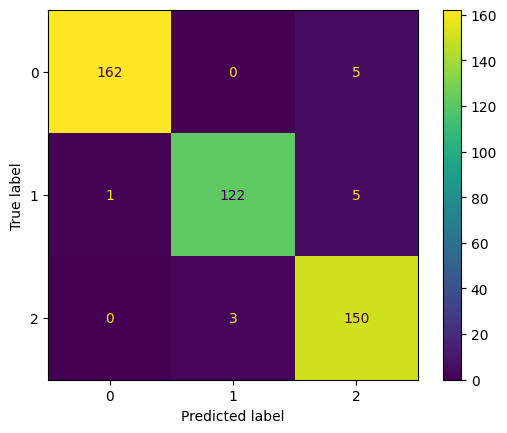

In [11]:

ConfusionMatrixDisplay.from_estimator(best_model, x_test, y_test)

**Report**
- Here RandomForestClassifier Work very well then other model'
- We got a good accuracy while predicting the test dataset.

### Storing the model into pickle

In [12]:
import pickle as pkl

model_path="model.pkl"
with open(model_path,"wb") as model_file:
    pkl.dump(best_model,model_file)



print("model saved sucessfully",{model_path})

model saved sucessfully {'model.pkl'}
